In [2]:
import random

import torch
import torch.nn as nn
from torch.optim import Adam

from torch.utils.data import DataLoader

from torchvision.datasets import MNIST, ImageFolder
from torchvision.utils import make_grid, save_image
from torchvision import transforms

from tqdm import tqdm

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print('Using device : {}'.format(device))

Using device : cuda:0


In [4]:
# For reproducible results.
manual_seed = 999
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)

In [5]:
mnist_dataset = MNIST(
  './mnist',
  train = True,
  download = True,
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
  ])
)

print("Dataset size: ", len(mnist_dataset))

batch_size = 64

training_dataloader = DataLoader(mnist_dataset, batch_size = batch_size, shuffle = True)

Dataset size:  60000


In [6]:
celeba_dataset = ImageFolder(
    "./celeba",
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
)

print("Dataset length:", len(celeba_dataset))

batch_size = 64

training_dataloader = DataLoader(celeba_dataset, batch_size = batch_size, shuffle = True)

Dataset length: 202599


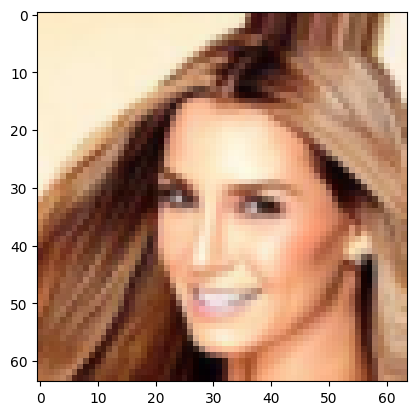

In [7]:
image, label = next(iter(celeba_dataset))

import matplotlib.pyplot as plt

# Denormalize
image = (image + 1.0) / 2.0

plt.imshow(image.permute(1, 2, 0))

In [8]:
images, label = next(iter(training_dataloader))

print('Image shape:', images.shape)
print('Label shape:', label.shape)

# print(images[0][0])

Image shape: torch.Size([64, 3, 64, 64])
Label shape: torch.Size([64])


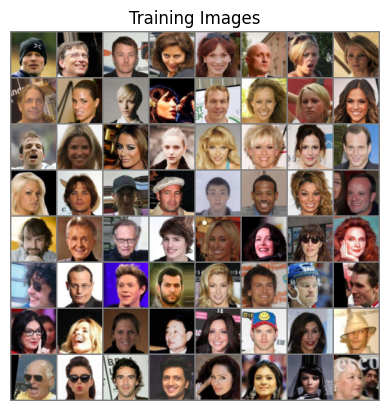

In [9]:
import matplotlib.pyplot as plt

image_grid = make_grid(images)

# Denormalize
image_grid = (image_grid + 1.) / 2.

plt.axis("off")
plt.title("Training Images")
plt.imshow((image_grid).permute(1, 2, 0))

In [10]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
        nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias = False),
        nn.BatchNorm2d(64 * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(64 * 4),
        nn.ReLU(True),

        nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(64 * 2),
        nn.ReLU(True),

        nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
        nn.Tanh()
    )

  def forward(self, x):
    img = self.model(x)
    return img
    # return img.reshape(-1, 1, 28, 28)

In [11]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      nn.Conv2d(3, 64, 4, 2, 1, bias = False),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.2, inplace = True),

      nn.Conv2d(64, 64 * 2, 4, 2, 1, bias = False),
      nn.BatchNorm2d(64 * 2),
      nn.LeakyReLU(0.2, inplace = True),

      nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias = False),
      nn.BatchNorm2d(64 * 4),
      nn.LeakyReLU(0.2, inplace = True),

      nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias = False),
      nn.BatchNorm2d(64 * 8),
      nn.LeakyReLU(0.2, inplace = True),

      nn.Conv2d(64 * 8, 1, 4, 1, 0, bias = False),
      nn.Sigmoid()
    )

  def forward(self, x):
    # x = x.reshape(-1, 28 * 28)
    return self.model(x)

In [12]:
# Loss function
bce_loss = nn.BCELoss().to(device)

# Initialize generator and discriminator
netG = Generator()
netD = Discriminator()

netG = netG.to(device)
netD = netD.to(device)


In [13]:
z = torch.randn((batch_size, 100, 1, 1), requires_grad = False).to(device)
outG = netG(z)
print(netD(outG).reshape(-1).shape)

torch.Size([64])


In [ ]:
num_epochs = 100

# Optimizers
optimizer_G = torch.optim.Adam(netG.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(netD.parameters(), lr = 0.0002, betas=(0.5, 0.999))

# tbar = tqdm(training_dataloader)
tbar = training_dataloader

LOAD_EPOCH = None

start_epoch = 0

if LOAD_EPOCH:
  checkpoint = torch.load('checkpoints/dcgan_{}.pth'.format(LOAD_EPOCH))
  netG.load_state_dict(checkpoint['model_state_dict'])
  netD.load_state_dict(checkpoint['discriminator_state_dict'])
  start_epoch = checkpoint['epochs'] + 1
  optimizer_G.load_state_dict(checkpoint['optimizer_G'])
  optimizer_D.load_state_dict(checkpoint['optimizer_D'])

netG.train()
netD.train()

for epoch in range(start_epoch, start_epoch + num_epochs):
  for index, (image, label) in enumerate(tbar):
    # Adversarial ground truths
    batch_size = image.shape[0]
    valid = torch.ones((batch_size,), requires_grad = False)
    fake = torch.zeros((batch_size,), requires_grad = False)

    # Noise input to generator.
    z = torch.randn((batch_size, 100, 1, 1), requires_grad = False)
    optimizer_D.zero_grad()

    valid = valid.to(device)
    fake = fake.to(device)
    z = z.to(device)
    image = image.to(device)
    generated = netG(z)

    # Train Generator
    optimizer_G.zero_grad()
    g_loss = bce_loss(netD(generated).reshape(-1), valid)

    g_loss.backward()
    optimizer_G.step()

    # Train discriminator
    real_loss = bce_loss(netD(image).reshape(-1), valid)
    fake_loss = bce_loss(netD(generated.detach()).reshape(-1), fake)

    d_loss = (real_loss + fake_loss) / 2.

    d_loss.backward()
    optimizer_D.step()

    # tbar.set_description(
    #   "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
    #   % (epoch, num_epochs, index, len(training_dataloader), d_loss.item(), g_loss.item())
    # )
    print(
      "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
      % (epoch, num_epochs, index, len(training_dataloader), d_loss.item(), g_loss.item())
    )
    # tbar.update()

    if index == len(training_dataloader) - 1:
      save_image(generated[:25], "results/%d.png" % epoch, nrow = 5, normalize = True)


  torch.save({
    'epochs': epoch,
    'optimizer_G': optimizer_G.state_dict(),
    'optimizer_D': optimizer_D.state_dict(),
    'model_state_dict': netG.state_dict(),
    'discriminator_state_dict': netD.state_dict(),
  }, 'checkpoints/dcgan_{}.pth'.format(epoch))

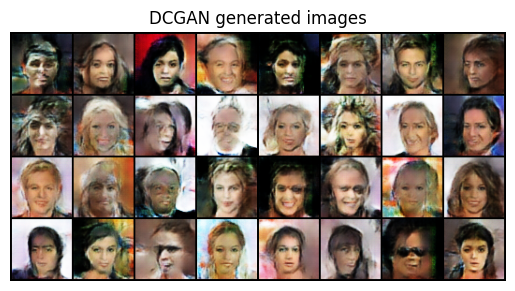

In [17]:
checkpoint = torch.load('checkpoints/dcgan__1.pth')

netG.load_state_dict(checkpoint['model_state_dict'])

netG.eval()

z = torch.randn(batch_size, 100, 1, 1).to(device)

result = netG(z)

result = (result + 1.) / 2.
plt.title("DCGAN generated images")
plt.axis('off')
plt.imshow(make_grid(result.cpu()[:32]).permute(1, 2, 0))